Week 6 Notebook: Evalulating Model Performance and Robustness
===============================================================

Let's take a look at the model performance and dependence on other variables.

In [1]:
import keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

Using TensorFlow backend.


In [2]:
# 48 track-level features
features = ['track_pt',
            'track_ptrel',
            'trackBTag_Eta',
            'trackBTag_DeltaR',
            'trackBTag_EtaRel',
            'trackBTag_JetDistVal',
            'trackBTag_Momentum',
            'trackBTag_PPar',
            'trackBTag_PParRatio',
            'trackBTag_PtRatio',
            'trackBTag_PtRel',
            'trackBTag_Sip2dSig',
            'trackBTag_Sip2dVal',
            'trackBTag_Sip3dSig',
            'trackBTag_Sip3dVal',
            'track_VTX_ass',
            'track_charge',
            'track_deltaR',
            'track_detadeta',
            'track_dlambdadz',
            'track_dlambdadz',
            'track_dphidphi',
            'track_dphidxy',
            'track_dptdpt',
            'track_drminsv',
            'track_drsubjet1',
            'track_drsubjet2',
            'track_dxy',
            'track_dxydxy',
            'track_dxydz',
            'track_dxysig',
            'track_dz',
            'track_dzdz',        
            'track_dzsig',
            'track_erel',
            'track_etarel',
            'track_fromPV',
            'track_isChargedHad',
            'track_isEl',
            'track_isMu',
            'track_lostInnerHits',
            'track_mass',
            'track_normchi2',            
            'track_phirel',
            'track_pt',
            'track_ptrel',
            'track_puppiw',
            'track_quality']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb (we'll reduce the following labels)
labels =  ['label_QCD_b',
           'label_QCD_bb',
           'label_QCD_c', 
           'label_QCD_cc', 
           'label_QCD_others',
           'sample_isQCD',
           'label_H_bb']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = 2

# we're going to zero-pad up to 60 tracks
ntracks = 60

In [3]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_files, features, labels, spectators, batch_size=1024, n_dim=60, 
                 remove_mass_pt_window=False, remove_unlabeled=True, return_spectators=False,
                 max_entry = 20000):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_files = list_files
        self.features = features
        self.spectators = spectators
        self.return_spectators = return_spectators
        self.n_dim = n_dim
        self.n_channels = len(features)
        self.remove_mass_pt_window = remove_mass_pt_window
        self.remove_unlabeled = remove_unlabeled
        self.global_IDs = []
        self.local_IDs = []
        self.file_mapping = []
        self.max_entry = max_entry
        self.open_files = [None]*len(self.list_files)
        running_total = 0
        for i, file_name in enumerate(self.list_files):
            root_file = uproot.open(file_name)
            self.open_files.append(root_file)
            tree = root_file['deepntuplizer/tree']
            tree_length = min(len(tree),max_entry)
            self.global_IDs.append(np.arange(running_total,running_total+tree_length))
            self.local_IDs.append(np.arange(tree_length))
            self.file_mapping.append(np.repeat(i,tree_length))
            running_total += tree_length
            root_file.close()
        self.global_IDs = np.concatenate(self.global_IDs)
        self.local_IDs = np.concatenate(self.local_IDs)
        self.file_mapping = np.concatenate(self.file_mapping)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.global_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        files = self.file_mapping[index*self.batch_size:(index+1)*self.batch_size]
        
        unique_files = np.unique(files)
        starts = np.array([min(indexes[files==i]) for i in unique_files])
        stops = np.array([max(indexes[files==i]) for i in unique_files])

        # Check if files needed open (if not open them)
        # Also if file is not needed, close it
        for ifile, file_name in enumerate(self.list_files):
            if ifile in unique_files:
                if self.open_files[ifile] is None: 
                    self.open_files[ifile] = uproot.open(file_name)
            else:
                if self.open_files[ifile] is not None: 
                    self.open_files[ifile].close()
                    self.open_files[ifile] = None
            
        # Generate data
        return self.__data_generation(unique_files, starts, stops)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.local_IDs

    def __data_generation(self, unique_files, starts, stops):
        'Generates data containing batch_size samples' 
        # X : (n_samples, n_dim, n_channels)
        # y : (n_samples, 2)
        Xs = []
        ys = []
        zs = []
        
        # Generate data
        for ifile, start, stop in zip(unique_files, starts, stops):
            if self.return_spectators:
                X, y, z = self.__get_features_labels(ifile, start, stop)
                zs.append(z)
            else:
                X, y = self.__get_features_labels(ifile, start, stop)
            Xs.append(X)
            ys.append(y)
            
        # Stack data if going over multiple files
        if len(unique_files)>1:
            X = np.concatenate(Xs,axis=0)
            y = np.concatenate(ys,axis=0)
            if self.return_spectators:
                z = np.concatenate(zs,axis=0)
            
        if self.return_spectators:
            return X, y, z
        
        return X, y
                         
    def __get_features_labels(self, ifile, entrystart, entrystop):
        'Loads data from one file'
        
        # Double check that file is open
        if self.open_files[ifile] is None:
            root_file = uproot.open(self.list_file[ifile])
        else:
            root_file = self.open_files[ifile]
            
        tree = root_file['deepntuplizer/tree']
        
        feature_array = tree.arrays(branches=self.features, 
                                    entrystart=entrystart,
                                    entrystop=entrystop,
                                    namedecode='utf-8')

        label_array_all = tree.arrays(branches=self.labels, 
                                      entrystart=entrystart,
                                      entrystop=entrystop,
                                      namedecode='utf-8')

        X = np.stack([feature_array[feat].pad(self.n_dim, clip=True).fillna(0).regular() for feat in features],axis=2)
        n_samples = X.shape[0]
    
        y = np.zeros((n_samples,2))
        y[:,0] = label_array_all['sample_isQCD'] * (label_array_all['label_QCD_b'] + \
                                                    label_array_all['label_QCD_bb'] + \
                                                    label_array_all['label_QCD_c'] + \
                                                    label_array_all['label_QCD_cc'] + \
                                                    label_array_all['label_QCD_others'])
        y[:,1] = label_array_all['label_H_bb']

        
        if self.remove_mass_pt_window:
            # remove data outside of mass/pT range
            spec_array = tree.arrays(branches=self.spectators, 
                                     entrystart=entrystart,
                                     entrystop=entrystop,
                                     namedecode='utf-8')
            
            z = np.stack([spec_array[spec] for spec in self.spectators],axis=1)
            X = X[(z[:,0] > 40) & (z[:,0] < 200) & (z[:,1] > 300) & (z[:,1] < 2000)]
            y = y[(z[:,0] > 40) & (z[:,0] < 200) & (z[:,1] > 300) & (z[:,1] < 2000)]
            z = z[(z[:,0] > 40) & (z[:,0] < 200) & (z[:,1] > 300) & (z[:,1] < 2000)]
                        
        if self.remove_unlabeled:
            # remove unlabeled data
            X = X[np.sum(y,axis=1)==1]
            if self.return_spectators:
                z = z[np.sum(y,axis=1)==1]
            y = y[np.sum(y,axis=1)==1]
            
        if self.return_spectators:
            return X, y, z
        
        return X, y

## Load the Previous Model
Here, we will load the last model trained in Notebook 5.

In [4]:
# define callbacks
from keras.models import load_model

keras_model_conv1d = load_model('keras_model_conv1d_best.h5')

## Configure Data Generator for Testing

We will configure the data generator to load testing data, including "spectator variables" that we were not used in the training, but may be correlated with the output of the algorithm. Specifically, the jet mass and pT.

In [7]:
# load testing file
test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root',
              'root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_1.root',
             ]
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=8192, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True,
                               return_spectators=True,
                               max_entry = 1000000) # no maximum

100%|██████████| 48/48 [05:38<00:00,  7.05s/it]


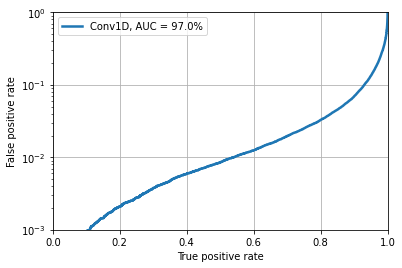

In [8]:
import tqdm
# run model inference on test data set
predict_array_cnn = []
label_array_test = []
spec_array_test = []

for t in tqdm.tqdm(test_generator,total=len(test_generator)):
    label_array_test.append(t[1])
    spec_array_test.append(t[2])
    predict_array_cnn.append(keras_model_conv1d.predict(t[0]))
    
predict_array_cnn = np.concatenate(predict_array_cnn,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)
spec_array_test = np.concatenate(spec_array_test,axis=0)

# create ROC curves
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(label_array_test[:,1], predict_array_cnn[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_cnn, fpr_cnn, lw=2.5, label="Conv1D, AUC = {:.1f}%".format(auc(fpr_cnn,tpr_cnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [9]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

## Correlation with jet mass
This algorithm has a slight dependence on jet mass. Qualitatively, we can observe this "mass sculpting" by making the distributino of the jet mass with tighter and tighter requirements on the algorithm output. We can see that the original distribution of the jet mass for the background has no "resonance" or bump, and is basically smoothly falling. 

However, once a requirement is made on the algorithm output, jets with low mass or high mass are excluded at higher rates. 

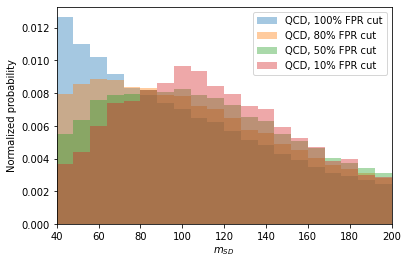

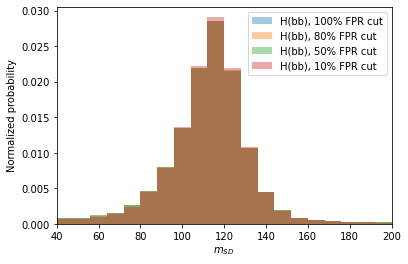

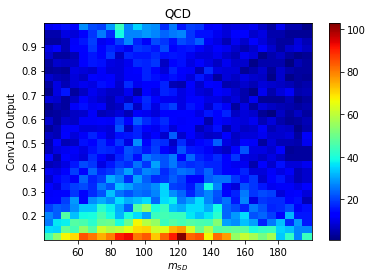

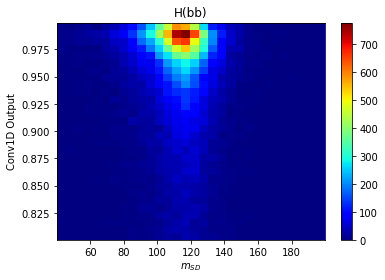

In [96]:
plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_cnn, wp)
    plt.hist(spec_array_test[:,0], bins = np.linspace(40, 200, 21), 
             weights = label_array_test[:,0]*(predict_array_cnn[:,1] > threshold_cnn[idx]),
             alpha=0.4,density=True, label='QCD, {}% FPR cut'.format(int(wp*100)),linestyle='-')
plt.legend()
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability')
plt.xlim(40,200)

plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_cnn, wp)
    plt.hist(spec_array_test[:,0], bins = np.linspace(40, 200, 21), 
             weights = label_array_test[:,1]*(predict_array_cnn[:,1] > threshold_cnn[idx]),
             alpha=0.4,density=True, label='H(bb), {}% FPR cut'.format(int(wp*100)),linestyle='-')
plt.legend()
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability')
plt.xlim(40,200)

plt.figure()
plt.hist2d(spec_array_test[:,0][(label_array_test[:,0]==1) & (predict_array_cnn[:,1] > 0.1)], 
           predict_array_cnn[:,1][(label_array_test[:,0]==1) & (predict_array_cnn[:,1] > 0.1)], 
           bins=(30, 30), 
           cmap=plt.cm.jet)
plt.colorbar()
plt.title('QCD')
plt.ylabel(r'Conv1D Output')
plt.xlabel(r'$m_{SD}$')

plt.figure()
plt.hist2d(spec_array_test[:,0][(label_array_test[:,1]==1) & (predict_array_cnn[:,1] > 0.8)], 
           predict_array_cnn[:,1][(label_array_test[:,1]==1) & (predict_array_cnn[:,1] > 0.8)], 
           bins=(30, 30), 
           cmap=plt.cm.jet)
plt.colorbar()
plt.title('H(bb)')
plt.ylabel(r'Conv1D Output')
plt.xlabel(r'$m_{SD}$')

plt.show()

## Dependence on jet pT

We can repeat the exercise this time looking at jet pT. We see that in general, higher pT jets are promoted to be more "signal-like" by the algorithm. This is likely due to the fact that high pT jets are over-represented in the signal sample compared to the background sample.

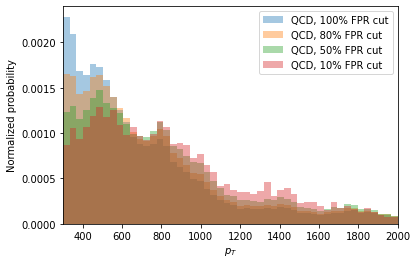

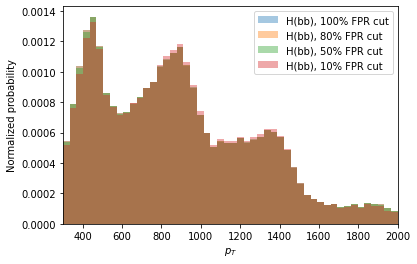

In [61]:
plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_cnn, wp)
    plt.hist(spec_array_test[:,1], bins = np.linspace(300, 2000, 51), 
             weights = label_array_test[:,0]*(predict_array_cnn[:,1] > threshold_cnn[idx]),
             alpha=0.4,density=True, label='QCD, {}% FPR cut'.format(int(wp*100)),linestyle='-')

plt.legend()
plt.xlabel(r'$p_{T}$')
plt.ylabel(r'Normalized probability')
plt.xlim(300,2000)

plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_cnn, wp)
    plt.hist(spec_array_test[:,1], bins = np.linspace(300, 2000, 51), 
             weights = label_array_test[:,1]*(predict_array_cnn[:,1] > threshold_cnn[idx]),
             alpha=0.4,density=True, label='H(bb), {}% FPR cut'.format(int(wp*100)),linestyle='-')

plt.legend()
plt.xlabel(r'$p_{T}$')
plt.ylabel(r'Normalized probability')
plt.xlim(300,2000)
plt.show()